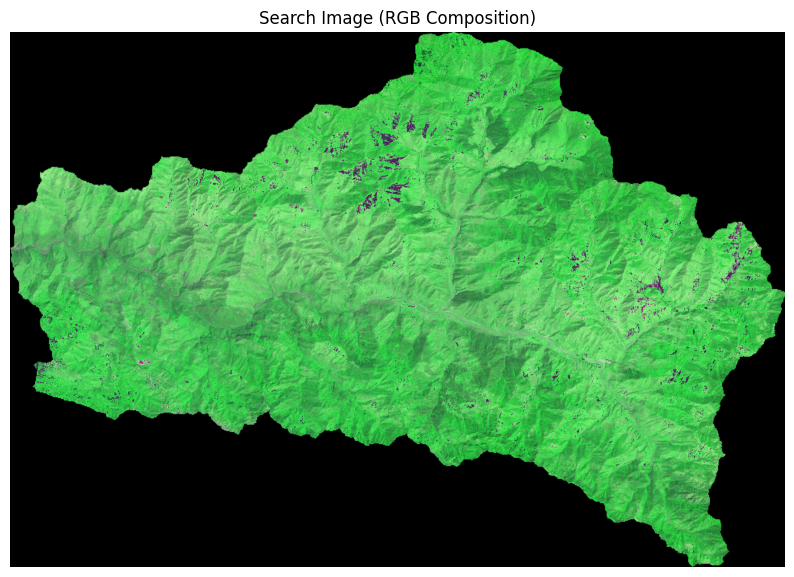

In [4]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Load the multispectral .img file (search image) and select bands for NIR, Red, Green
search_image_path = '/home/shivaye/btp2/15april2017_clip.img'
template_path1 = '/home/shivaye/btp2/terrace_template_final_first.tif'
template_path2 = '/home/shivaye/btp2/terrace_template_final_second.tif'

# Step 1: Open the search image with rasterio
with rasterio.open(search_image_path) as src:
    # Read the NIR, Red, and Green bands (assuming the bands are ordered as follows: NIR = Band 3, Red = Band 2, Green = Band 1)
    nir_band = src.read(3)  # NIR band
    red_band = src.read(2)  # Red band
    green_band = src.read(1)  # Green band

    # Combine bands into an RGB image for visualization
    rgb_image = np.zeros((nir_band.shape[0], nir_band.shape[1], 3), dtype=np.uint8)
    rgb_image[..., 0] = red_band  # Red channel
    rgb_image[..., 1] = green_band  # Green channel
    rgb_image[..., 2] = nir_band  # Blue channel (using NIR for blue)

# Step 2: Display the search image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)   
plt.title("Search Image (RGB Composition)")
plt.axis('off')  # Hide axes
plt.show()

# Step 3: Open the template images and print dimensions
with rasterio.open(template_path1) as template_src1, rasterio.open(template_path2) as template_src2:
    # Template 1 (ignoring the last row and column)
    template1_nir = template_src1.read(3)[:-1, :-1]
    template1_red = template_src1.read(2)[:-1, :-1]
    template1_green = template_src1.read(1)[:-1, :-1]
    # print(f"Template 1 dimensions: Height = {template1_nir.shape[0]}, Width = {template1_nir.shape[1]}")
    
    # Template 2 (ignoring the last row only)
    template2_nir = template_src2.read(3)[:-1]
    template2_red = template_src2.read(2)[:-1]
    template2_green = template_src2.read(1)[:-1]
    # print(f"Template 2 dimensions: Height = {template2_nir.shape[0]}, Width = {template2_nir.shape[1]}")

# Step 4: Define a function to calculate the gray variance for multispectral bands
def calculate_multispectral_variance(sample, template):
    """Calculate the gray variance for multispectral bands."""
    variance_nir = np.sum((sample[0] - template[0]) ** 2)
    variance_red = np.sum((sample[1] - template[1]) ** 2)
    variance_green = np.sum((sample[2] - template[2]) ** 2)
    return variance_nir + variance_red + variance_green  # Combine variances

# Step 5: Prepare the variance images
variance_image1 = np.zeros_like(nir_band, dtype=np.float32)
variance_image2 = np.zeros_like(nir_band, dtype=np.float32)

# Step 6: Perform pixel-by-pixel scanning and calculate variances for both templates
half_height1 = template1_nir.shape[0] // 2
half_width1 = template1_nir.shape[1] // 2
half_height2 = template2_nir.shape[0] // 2
half_width2 = template2_nir.shape[1] // 2

# Create lists to store valid variances for normalization
valid_variances1 = []
valid_variances2 = []

# Calculate variances for template 1
for i in range(half_height1, nir_band.shape[0] - half_height1):
    for j in range(half_width1, nir_band.shape[1] - half_width1):
        # Extract a sample region for each band
        sample = np.array([
            nir_band[i - half_height1:i + half_height1 + 1, j - half_width1:j + half_width1 + 1],
            red_band[i - half_height1:i + half_height1 + 1, j - half_width1:j + half_width1 + 1],
            green_band[i - half_height1:i + half_height1 + 1, j - half_width1:j + half_width1 + 1]
        ])
        
        if sample.shape[1:] == template1_nir.shape and np.all(sample != 65536):
            variance1 = calculate_multispectral_variance(sample, [template1_nir, template1_red, template1_green])
            variance_image1[i, j] = variance1
            valid_variances1.append(variance1)
    # print(f"Template 1 processing: row {i}")

# Calculate variances for template 2
for i in range(half_height2, nir_band.shape[0] - half_height2):
    for j in range(half_width2, nir_band.shape[1] - half_width2):
        # Extract a sample region for each band
        sample = np.array([
            nir_band[i - half_height2:i + half_height2 + 1, j - half_width2:j + half_width2 + 1],
            red_band[i - half_height2:i + half_height2 + 1, j - half_width2:j + half_width2 + 1],
            green_band[i - half_height2:i + half_height2 + 1, j - half_width2:j + half_width2 + 1]
        ])
        
        if sample.shape[1:] == template2_nir.shape and np.all(sample != 65536):
            variance2 = calculate_multispectral_variance(sample, [template2_nir, template2_red, template2_green])
            variance_image2[i, j] = variance2
            valid_variances2.append(variance2)
    # print(f"Template 2 processing: row {i}")

# Step 7: Normalize each variance image


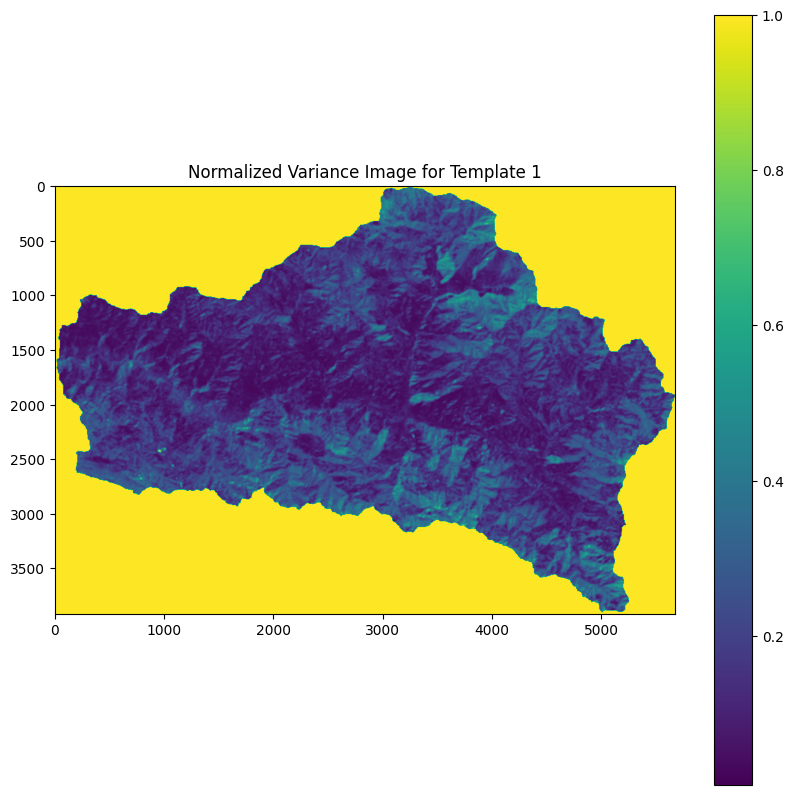

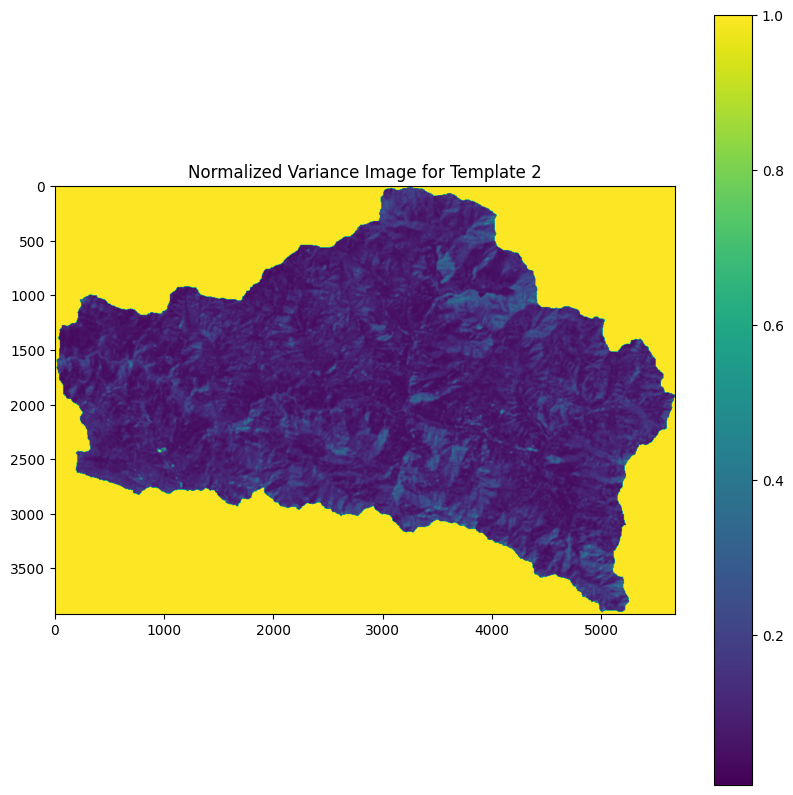

Number of terraces: 5519


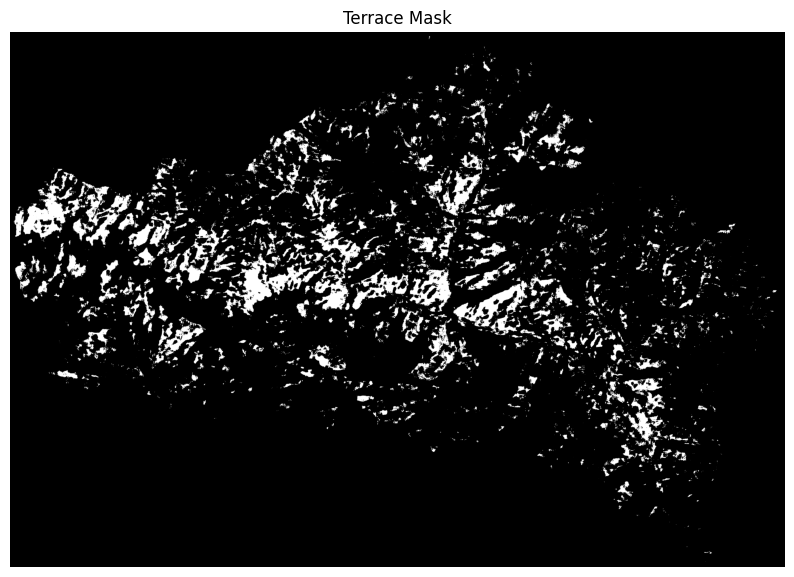

In [5]:
if valid_variances1:
    min_var1, max_var1 = min(valid_variances1), max(valid_variances1)
    variance_image1 = np.where(variance_image1 != 0, (variance_image1 - min_var1) / (max_var1 - min_var1), 1)

if valid_variances2:
    min_var2, max_var2 = min(valid_variances2), max(valid_variances2)
    variance_image2 = np.where(variance_image2 != 0, (variance_image2 - min_var2) / (max_var2 - min_var2), 1)

# Step 8: Display the normalized variance images
plt.figure(figsize=(10, 10))
plt.imshow(variance_image1, cmap='viridis')
plt.title("Normalized Variance Image for Template 1")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(variance_image2, cmap='viridis')
plt.title("Normalized Variance Image for Template 2")
plt.colorbar()
plt.show()

# Step 9: Combine both variance images and apply threshold to identify terraces
variance_threshold = 0.05  # Example threshold; adjust based on dataset characteristics
terrace_mask = (variance_image1 < variance_threshold) | (variance_image2 < variance_threshold)

labeled_mask, num_terraces = label(terrace_mask)

print(f"Number of terraces: {num_terraces}")

# Step 10: Display the terrace mask
plt.figure(figsize=(10, 10))
plt.imshow(terrace_mask, cmap='gray')
plt.title("Terrace Mask")
plt.axis('off')  # Hide axes
plt.show()


In [6]:
import rasterio
from rasterio.transform import from_origin

# Define the path where the terrace mask will be saved
output_terrace_mask_path = '/home/shivaye/btp2/terrace_mask.tif'

# Step 1: Save the terrace mask
with rasterio.open(search_image_path) as src:
    # Define metadata for the output file based on the search image
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "dtype": 'uint8',  # terrace_mask is binary (0 or 1), so we can use uint8
        "count": 1,  # Single band for terrace mask
        "compress": "lzw",  # Opti  onal: compress the output file
        "nodata": None  # Remove the nodata value for compatibility with uint8
    })

    # Write the terrace mask as a new file
    with rasterio.open(output_terrace_mask_path, "w", **out_meta) as dest:
        dest.write(terrace_mask.astype(rasterio.uint8), 1)

print(f"Terrace mask saved to {output_terrace_mask_path}")


Terrace mask saved to /home/shivaye/btp2/terrace_mask.tif
